In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

In [2]:
class structtype():
    pass
# Matlab to Python conversion> https://stackoverflow.com/questions/11637045/complex-matlab-like-data-structure-in-python-numpy-scipy
# Python dictionaries> https://realpython.com/iterate-through-dictionary-python/

In [3]:
# class of RMB object
class grbm: # handle class, beware
#         V; #visible units subpopulation struct (S state,B biases, T type ['poiss' or 'bern'])
#         H; #hidden units subpopulation struct (S state,B biases, T type ['poiss' or 'bern'])
#         W; #weight matrixes struct. Element ph,pv is hidden population ph acting on visible population pv and viceversa
#         NV; #vector containing numbers of units for each visible population
#         NH; #vector containing numbers of units for each hidden population
#         Npv; #number of visible subpopulations
#         Nph; #number of hidden subpopulations
#         #state and bias vectors are COLUMN vectors
#         Names;#names of subpopulations
#         TrainParams;#training parameters
#         NeuronInfo;#neuron info
#         WUp;#weights arranged for the 'up' step
#         WDown;#weights arranged for the 'down' step
#         VUp;#all visible neurons
#         VDown;#all hidden neurons
#         persistentChain;

        
        #constructor
        def __init__(self,nv,nh,tv,th,names,trainparams,neuroninfo): #done
            self.V=[structtype(),structtype(),structtype()]
            self.H=[structtype(),structtype(),structtype()]
            self.W=[[structtype(),structtype(),structtype()]]
            self.NV=nv
            self.NH=nh
            self.Npv=np.size(self.NV)
            self.Nph=np.size(self.NH)
            self.Names=names
            self.TrainParams=trainparams
            self.NeuronInfo=neuroninfo
            self.WUp=[structtype(),structtype(),structtype()]
            self.WDown=[structtype(),structtype(),structtype()]
            
            for pv in np.arange(self.Npv):
                self.V[pv].S=np.zeros((self.NV[pv],1))
                self.V[pv].B=np.zeros((self.NV[pv],1))
                self.V[pv].T=tv[pv]
            
            for ph in np.arange(self.Nph):
                self.H[ph].S=np.zeros((self.NH[ph],1))
                self.H[ph].B=np.zeros((self.NH[ph],1))
                self.H[ph].T=th[ph]
            
            for pv in np.arange(self.Npv):
                for ph in np.arange(self.Nph):
                    self.W[ph][pv].W= np.random.normal(0,1,size=(self.NH[ph],self.NV[pv])) / np.sum(self.NH) #%%%%normalization has to be checked! BEWARE!
            for ph in np.arange(self.Nph):
                ww=0.01*np.random.normal(0,1,size=(self.NH[ph],np.sum(self.NV)))
                vv=np.zeros((np.sum(self.NV),1))
                inds=np.insert(np.cumsum(self.NV),0,0)
                for pv in np.arange(self.Npv):
                    currInds=np.arange(inds[pv],inds[pv+1])
                    ww[:,currInds]=self.W[ph][pv].W #%matrix acting on the subpopulation ph
                    vv[currInds]=self.V[pv].S  #%global visible activity
                    
                self.WUp[ph].W=ww
                self.VUp=vv
            
            for pv in np.arange(self.Npv):
                ww=0.01*np.random.normal(0,1,size=(np.sum(self.NH),self.NV[pv]))
                hh=np.zeros((np.sum(self.NH),1))
                inds=np.insert(np.cumsum(self.NH),0,0)
                for ph in np.arange(self.Nph):
                    currInds=np.arange(inds[ph],inds[ph+1])
                    ww[currInds,:]=self.W[ph][pv].W #%matrix acting on the subpopulation pv
                    hh[currInds]=self.H[ph].S    #%global hidden activity
        
                self.WDown[pv].W=ww
                self.VDown=hh
                if np.size(self.NeuronInfo[pv].n)==2:
                    self.NeuronInfo[pv].min=self.NeuronInfo[pv].center-self.NeuronInfo[pv].span/2+self.NeuronInfo[pv].sm
                    self.NeuronInfo[pv].max=self.NeuronInfo[pv].center+self.NeuronInfo[pv].span/2-self.NeuronInfo[pv].sm
                    self.NeuronInfo[pv].xAxis=np.linspace(self.NeuronInfo[pv].min[0]-self.NeuronInfo[pv].sm[0],self.NeuronInfo[pv].max[0]+self.NeuronInfo[pv].sm[0],self.NeuronInfo[pv].n[0])
                    self.NeuronInfo[pv].yAxis=np.linspace(self.NeuronInfo[pv].min[1]-self.NeuronInfo[pv].sm[1],self.NeuronInfo[pv].max[1]+self.NeuronInfo[pv].sm[1],self.NeuronInfo[pv].n[1])
    
                self.persistentChain=np.zeros((np.sum(self.NV),self.TrainParams.N_vects))
        
        #compute hidden layer given visible units
        def up(self): #done
            inds=np.insert(np.cumsum(self.NV),0,0)
            for pv in np.arange(self.Npv):
                currInds=np.arange(inds[pv],inds[pv+1])
                self.VUp[currInds]=self.V[pv].S    #global visible activity
            
            for ph in np.arange(self.Nph):
                if np.char.equal(self.H[ph].T,'bern'):
                    gv=self.WUp[ph].W@self.VUp+self.H[ph].B
                    mu=1/(1+np.exp(-gv))
                    mu=np.transpose(mu)
                    rr=np.random.rand(1,self.NH[ph])
                    self.H[ph].S=1*np.transpose(rr<mu)
                    self.H[ph].MU=np.transpose(mu)
                elif np.char.equal(self.H[ph].T,'poiss'):
                    gv=self.WUp[ph].W@self.VUp+self.H[ph].B
                    mu=np.exp(gv)
                    self.H[ph].S=np.random.poisson(mu)
                    self.H[ph].MU=np.transpose(mu)
                    
        # compute visible layer given hidden units
        def down(self): #done
            inds=np.insert(np.cumsum(self.NH),0,0)
            for ph in np.arange(self.Nph):
                currInds=np.arange(inds[ph],inds[ph+1])
                self.VDown[currInds]=self.H[ph].S; #global hidden activity
            
            for pv in np.arange(self.Npv):
                if np.char.equal(self.V[pv].T,'bern'):
                    gv=np.transpose(self.WDown[pv].W)@self.VDown+self.V[pv].B
                    mu=1/(1+np.exp(-gv))
                    mu=np.transpose(mu)
                    rr=np.random.rand(1,self.NV[pv])
                    self.V[pv].S=1*np.transpose(rr<mu)
                    self.V[pv].MU=np.transpose(mu)
                elif np.char.equal(self.V[pv].T,'poiss'):
                    gv=np.transpose(self.WDown[pv].W)@self.VDown+self.V[pv].B
                    mu=np.exp(gv)
                    self.V[pv].S=np.random.poisson(mu)
                    self.V[pv].MU=np.transpose(mu)
                    
        #compute hidden layer given visible units via fast matrix multiplication
        def fastUp(self,v): #done 
            w=self.allW()
            bh=self.allBh()
            gv=w@v+bh
            mu=1/(1+np.exp(-gv))
            rr=np.random.rand(np.size(mu.transpose()))
            h=1*(rr<mu.transpose()).transpose()
            return h,mu
        
        #compute hidden layer given visible units
        def fastDown(self,h): #done 
            w=self.allW()
            bv=self.allBv()
            gv=w.transpose()@h+bv
            mu=np.exp(gv)
            v=np.random.poisson(mu)
            return v,mu
        
        ## Set stuff
    
        #set visible units state from a single activity vector including all visible subpopulations
        def setV(self,ninput): 
            inind=0
            for pv in np.arange(self.Npv):
                self.V[pv].S=ninput[np.arange(inind,inind+self.NV[pv])]
                inind=inind+self.NV[pv]
        
        #set hidden unit state from a single activity vector including all hidden subpopulations
        def setH(self,ninput):  
            inind=0
            for ph in np.arange(self.Nph):
                self.H[ph].S=ninput[np.arange(inind,inind+self.NH[ph])]
                inind=inind+self.NH[ph]
           
        #set individual subpopulation weight matrix from a global weight matrix
        def setW(self,ninput): #done
            ini=0
            for ph in np.arange(self.Nph):
                inj=0
                for pv in np.arange(self.Npv):
                    self.W[ph][pv].W=ninput[ini:ini+self.NH[ph],inj:inj+self.NV[pv]]
                    inj=inj+self.NV[pv]
                ini=ini+self.NH[ph]
            
            for ph in np.arange(self.Nph):
                ww=np.zeros((self.NH[ph],np.sum(self.NV)))
                vv=np.zeros((np.sum(self.NV),1))
                inds=np.insert(np.cumsum(self.NV),0,0)
                for pv in np.arange(self.Npv):
                    currInds=np.arange(inds[pv],inds[pv+1])
                    ww[:,currInds]=self.W[ph][pv].W #matrix acting on the subpopulation ph
                    vv[currInds]=self.V[pv].S    #global visible activity
            
                self.WUp[ph].W=ww
                self.VUp=vv
            
            for pv in np.arange(self.Npv):
                ww=np.zeros((np.sum(self.NH),self.NV[pv]))
                hh=np.zeros((np.sum(self.NH),1))
                inds=np.insert(np.cumsum(self.NH),0,0)
                for ph in np.arange(self.Nph):
                    currInds=np.arange(inds[ph],inds[ph+1])
                    ww[currInds,:]=self.W[ph][pv].W #matrix acting on the subpopulation pv
                    hh[currInds]=self.H[ph].S    #global hidden activity
                
                self.WDown[pv].W=ww
                self.VDown=hh
        
        # set hidden units biases from a global vector        
        def setBh(self,ninput): #done
            inind=0
            for ph in np.arange(self.Nph):
                self.H[ph].B=ninput[inind:inind+self.NH[ph]]
                inind=inind+self.NH[ph]
            
        # set visible units biases from a global vector
        def setBv(self,ninput): #done
            inind=0
            for pv in np.arange(self.Npv):
                self.V[pv].B=ninput[inind:inind+self.NV[pv]]
                inind=inind+self.NV[pv]
                
        
        ## Get stuff
        #get global weight matrix from the individual subpopulations weight matrices
        def allW(self): #done
            ww=np.array([])
            for pv in np.arange(self.Npv):
                wh=np.array([])
                for ph in np.arange(self.Nph):
                    wh=np.vstack((wh,self.W[ph][pv].W)) if wh.size else self.W[ph][pv].W     
                ww=np.hstack((ww,wh)) if ww.size else wh
            return ww
        
        #get global visible units bias vector
        def allBv(self): #done
            bv=np.array([])
            for pv in np.arange(self.Npv):
                bv=np.vstack((bv,self.V[pv].B)) if bv.size else self.V[pv].B
            return bv
            
        #get global hidden units bias vector
        def allBh(self): #done
            bh=np.array([])
            for ph in np.arange(self.Nph):
                bh=np.vstack((bh,self.H[ph].B)) if bh.size else self.H[ph].B
            return bh
        
        #get global visible units state vector
        def allV(self): #done
            v=np.array([])
            for pv in np.arange(self.Npv):
                v=np.vstack((v,self.V[pv].S)) if v.size else self.V[pv].S
            return v
        
        #get global hidden units state vector
        def allH(self): #done
            h=np.array([])
            for ph in np.arange(self.Nph):
                h=np.vstack((h,self.H[ph].S)) if h.size else self.H[ph].S
            return h
        
        
        def energy(self): #done
            e=-self.allH().transpose()@self.allW()@self.allV()+np.sum(np.multiply(self.allV(),self.allBv()))-np.sum(np.multiply(self.allH(),self.allBh()))
            return e
        
        def logLikWrong(self): #done
            l=0
            for ph in np.arange(self.Nph):
                gv=self.WUp[ph].W@self.allV()+self.H[ph].B
                l=l+np.sum(np.log(1+np.exp(gv)))
            l=l+np.sum(np.multiply(self.allV(),self.allBv()))
            return l
        
        def logLik(self): #done
            l=0
            for ph in np.arange(self.Nph):
                gv=self.WUp[ph].W@self.allV()+self.H[ph].B
                l=l+np.sum(np.log(1+np.exp(gv)))
            e=0
            v=self.allV()
            print(v.sum())
            for i in np.arange(np.size(v)):
                e=e+np.sum(np.log(np.arange(1,v[i]))) #something is wrong. probably log. 
            l=l+np.sum(np.multiply(self.allV(),self.allBv()))-e
            return l
        
        #train using contrastive divergence on a [nsteps,NV] batch where
        #nsteps is the number of vectors of the batch and NV the total
        #number of visible units
        
        def train(self,batch,eta): #not used
            [null, nsteps]=np.shape(batch)
            dW=0*self.allW()
            dBv=0*self.allBv()
            dBh=0*self.allBh()
            for i in np.arange(nsteps):
                self.setV(batch[:,i])
                self.up()
                dW=dW+(self.allV()@self.allH().transpose()).transpose()
                dBv=dBv+self.allV()
                dBh=dBh+self.allH()
                
                self.down()
                self.up() 
                
                dW=dW-(self.allV()@self.allH().transpose()).transpose()
                dBv=dBv-self.allV()
                dBh=dBh-self.allH()
        
            self.setW(self.allW()+eta*dW)
            self.setBv(self.allBv()+eta*dBv)
            self.setBh(self.allBh()+eta*dBh)
        
        #show the parameters
        def showpars(self,Plot): #done
            if Plot:
                plt.figure(1)
                count=0
                fig, axs = plt.subplots(1,np.sum((np.size(self.NV),np.size(self.NH))))
                for ind in np.arange(np.size(self.NV)):
                    count=count+1
                    axs[count-1].plot(self.V[ind].B)
                    axs[count-1].set_title('bias\n'+self.Names.V[ind])
                
                for ind in np.arange(np.size(self.NH)):
                    count=count+1
                    axs[count-1].plot(self.H[ind].B)
                    axs[count-1].set_title('bias\n' + self.Names.H[ind])
                fig.subplots_adjust(wspace=1.25)
           
            nr, nc=np.shape(self.W)
            count=0
            
            #sort according to peak of receptive field
            wcurr=self.W
            if np.size(wcurr)>2:
                order=np.argsort(np.nanmean(wcurr[0][2].W,1))
            else:
                order=np.arange(np.shape(wcurr[0].W,0));
            
            for i in np.arange(nr):
                for j in np.arange(nc):
                    wcurr[i][j].W=wcurr[i][j].W[order,:]
            
            if Plot:
                plt.figure(2)
                fig2, axs2 = plt.subplots(nr,nc)        
                for i in np.arange(nr):
                    for j in np.arange(nc):
                        count=count+1
                        ww=wcurr[i][j].W
                        im=axs2[count-1].imshow(ww,aspect="auto") 
                        axs2[count-1].set_title(self.Names.V[j]+'\n'+self.Names.H[i])
                        divider = make_axes_locatable(axs2[count-1])
                        cax = divider.append_axes("right", "10%", pad="3%")
                        fig2.colorbar(im, cax=cax)
                fig2.subplots_adjust(wspace=2)
            return wcurr,order
        
        def showstate(self): # done
            count=0;
            fig, axs = plt.subplots(1,np.sum((np.size(self.NV),np.size(self.NH))))
            for ind in np.arange(np.size(self.NV)):
                count=count+1
                s=self.V[ind].S
                if np.size(self.NeuronInfo[ind].n)>1:
                    s=np.reshape(s,self.NeuronInfo[ind].n)
                im=axs[count-1].imshow(s,aspect="auto")
                axs[count-1].set_title(self.Names.V[ind])
                  
            order=np.argsort(np.mean(self.W[0][-1].W,1))
            for ind in np.arange(np.size(self.NH)):
                count=count+1
                im=axs[count-1].imshow(self.H[ind].S[order],aspect="auto")
                axs[count-1].set_title(self.Names.H[ind])
            fig.subplots_adjust(wspace=1)
            
        def getPosition(self): #done
            pos=[];
            for pv in np.arange(self.Npv):
                if np.size(self.NeuronInfo[pv].n)==2:
                    wx,wy=np.meshgrid(np.arange(self.NeuronInfo[pv].n[0]),np.arange(self.NeuronInfo[pv].n[1]))
                    w=np.flipud(np.rot90(np.reshape(self.V[pv].S,self.NeuronInfo[pv].n)))
                    barX=np.sum(np.sum(np.multiply(w,wx)))/np.sum(w)
                    barY=np.sum(np.sum(np.multiply(w,wy)))/np.sum(w)
                    pos.append(structtype())
                    pos[pv].posNeurons=[barX,barY]
                    pos[pv].posMeters=indToPos(pos[pv].posNeurons,self.NeuronInfo[pv])
            return pos
        
        def plotPop(self,pv):
            s=np.reshape(self.V[pv].S,self.NeuronInfo[pv].n)
            s=np.flipud(np.rot90(s))
            #plt.imshow(self.NeuronInfo[pv].xAxis,self.NeuronInfo[pv].yAxis,s)
            plt.imshow(s) #extent> https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html
            return s

In [4]:
# compute position in meters given position in neuron units
def indToPos(ind,neuronInfo):
    pos=(neuronInfo.center-neuronInfo.span/2)+np.multiply((np.array(ind)-1),neuronInfo.span)/(neuronInfo.n-1)
    return pos

# compute position in neuron units given position in meters
def posToInd(pos,neuronInfo):
    ind=1+np.multiply((neuronInfo.n-1),(pos-neuronInfo.center+neuronInfo.span/2))/neuronInfo.span
    #ind=1+(neuronInfo.n-1).*(pos-neuronInfo.center+neuronInfo.span/2)./neuronInfo.span;
    return ind

# generate a population code for tactile, visual and proprioceptive stimuli
def stimgen(pBc,pH,neuronInfo,gains): #done
# INPUT:
# pBc: stimulus position in body centered coordinates
# pH: stimulus position in body centered coordinates
# neuronInfo: structure containing info about tuning curves, number of
# neurons etc for various populations. It is one of the properties of an RBM
# object
# gains: vector with gains of the different neural populations

# OUTPUT
# Bc: population encoding stimulus in body centered coordinates
# H: population encoding hand position
# T: tactile population

    dCp=.15 #hand radius
    slope=100000 #"sharpness" of tactile RF

    #body centered
    g1=gains[0] # chose gain 
    [xg,yg]=np.meshgrid(np.arange(neuronInfo[0].n[0])+1,np.arange(neuronInfo[0].n[1])+1) #grid of coordinates
    pos=posToInd(pBc,neuronInfo[0])
    Bc=g1*np.exp((-(pos[0]-xg)**2-(pos[1]-yg)**2)/(2*neuronInfo[0].tc**2))#.T
    Bc=Bc.flatten()
    
    #hand
    g2=gains[1] # chose gain according to Makin & Sabes 2015
    [xg,yg]=np.meshgrid(np.arange(neuronInfo[1].n[0])+1,np.arange(neuronInfo[1].n[1])+1)
    pos=posToInd(pH,neuronInfo[1])
    H=g2*np.exp((-(pos[0]-xg)**2-(pos[1]-yg)**2)/(2*neuronInfo[1].tc**2))#.T
    H=H.flatten()
    
    pHc=pBc-pH #hand centered position
    g3=gains[2]
    d=np.linalg.norm(pHc) #distance from hand
    elambda = 1-np.exp(slope*(d-dCp))/(1+np.exp(slope*(d-dCp)))
    if np.isnan(elambda): elambda=0
        
    #tactile population
    T=g3*elambda*np.ones((neuronInfo[2].n,1))
    
    return Bc, H, T

In [5]:
pCouple=0
NV=[2500,150,30] #number of visible units
NH=[1500] #number of hidden units

neuronInfo=[structtype(),structtype(),structtype()]
neuronInfo[0].span=np.asarray([1.8,1.8])# x,y span
neuronInfo[0].sm=np.asarray([.3,.3]) #x,y safety margin against edge effects (symmetric)
neuronInfo[0].center=np.asarray([0,.6]) #where the center of the neural population is in trunk centered coordinates;
neuronInfo[0].n=np.asarray([50,50]) #nx,ny
neuronInfo[0].tc=3 #tuning curve width (neurons)

neuronInfo[1].span=np.asarray([2,1.4]) #x,y span
neuronInfo[1].sm=np.asarray([.4,.4]) #x,y safety margin against edge effects (symmetric)
neuronInfo[1].center=np.asarray([0,.3]) #where the center of the neural population is in trunk centered coordinates;
neuronInfo[1].n=np.asarray([15,10]) #nx,ny
neuronInfo[1].tc=1 #tuning curve width (neurons)

neuronInfo[2].n=NV[2]

N_epochs=16 #160
N_batches=40 #400

N_vects=100
total_annealing=1
Cp=N_epochs/8
Slope=N_epochs/20
dE=1 #plot and save every dE epochs
eta=5e-6###this value of eta hasn't been optimized, but it's more or less OK
etas=((eta/total_annealing)+eta*np.exp(-((np.arange(N_epochs))-Cp)/Slope))/(1+np.exp(-((np.arange(N_epochs))-Cp)/Slope))-np.linspace(0,eta/total_annealing,N_epochs)
tocOld=0

Names = structtype()
Names.V=['body centered','hand position','tactile'] #names of populations
Names.H=['hidden']

TrainParams = structtype()
TrainParams.N_epochs=N_epochs
TrainParams.N_batches=N_batches
TrainParams.N_vects=N_vects
TrainParams.TotalAnnealing=total_annealing
TrainParams.Etas=etas
g=grbm(NV,NH,['poiss','poiss','poiss'],['bern'],Names,TrainParams,neuronInfo) #population types (bernoulli or poisson)
res=[]

In [71]:
w = g.allW()
v = g.allV()
h,mu = g.fastUp(v)
v,mu = g.fastDown(h)

gains=4+6*np.random.rand(3,1)
Bc,H,T=stimgen(0.7,0.7,g.NeuronInfo,gains)
mystim=[Bc, H, T]

In [67]:
g2.up()
g2.down()

<Figure size 4800x3600 with 0 Axes>

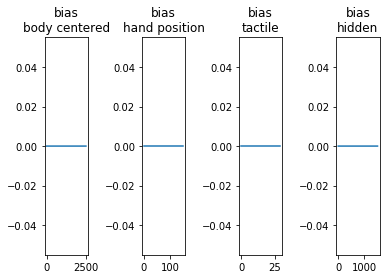

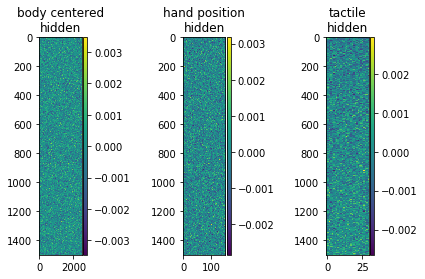

In [68]:
myw,myor = g2.showpars(True)

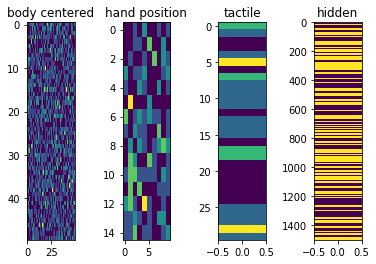

In [69]:
g2.showstate()

array([[0, 0, 1, ..., 2, 2, 2],
       [2, 0, 2, ..., 2, 2, 1],
       [1, 2, 0, ..., 1, 2, 1],
       ...,
       [1, 3, 1, ..., 2, 0, 1],
       [0, 0, 1, ..., 1, 2, 0],
       [1, 0, 2, ..., 0, 1, 1]])

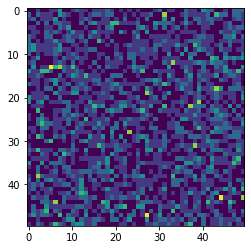

In [57]:
#mypos=g.getPosition()
g2.plotPop(0)

In [ ]:
# actual training
stims=np.zeros((np.sum(g.NV),N_vects))
hiddenState=np.zeros((g.NH[0],N_vects))

for epoch in range(N_epochs):
    re=0
    g.TrainParams.TrainingCompleted=False
    countb=0
    eta=etas[epoch]
    #get weights from the rmb objects, calculations for training are done
    #outside the object for efficiency
    w=g.allW()
    bh=g.allBh()
    bv=g.allBv()
    
    for batch in range(N_batches): #a batch is made by N_vects individual stimuli
        #generate stimuli
        for i in range(N_vects):
            pH= np.multiply(g.NeuronInfo[1].min+(g.NeuronInfo[1].max-g.NeuronInfo[1].min),*np.random.rand(1,2))
            #double check H and stimgen function for H
            if np.random.rand()>pCouple:
                pBc=g.NeuronInfo[0].min-.15+ np.multiply((.3+g.NeuronInfo[0].max-g.NeuronInfo[0].min),*np.random.rand(1,2))
            else:
                pBc=pH+.15*np.random.normal(1,2)
            gains=4+6*np.random.rand(3,1)
            Bc,H,T=stimgen(pBc,pH,g.NeuronInfo,gains)
            stims[:,i]=np.concatenate((np.hstack(Bc),np.hstack(H),np.hstack(T)))
        stims=np.random.poisson(stims)
        
        #one-step contrastive divergence, done for all stimuli in a batch
        #at once for efficiency
        #up
        gv=w@stims+bh
        mu=1/(1+np.exp(-gv))
        mu=mu.T
        rr=np.random.rand(*np.shape(mu))
        h=1*(rr<mu).T
        
        dW=h@stims.T
        dBv=np.sum(stims,1)
        dBh=np.sum(h,1)
        
        #down
        gv=w.T@h+bv
        mu=np.exp(gv)
        v=np.random.poisson(mu)
        
        #up
        gv=w@v+bh
        mu=1/(1+np.exp(-gv))
        mu=mu.T
        rr=np.random.rand(*np.shape(mu))
        h=1*(rr<mu).T
        
        dW=dW-h@v.T
        dBv=dBv-np.sum(v,1)
        dBh=dBh-np.sum(h,1)
        
        #update weights and biases
        w=w+eta*dW
        bv=bv+eta*dBv.reshape((2680,1))
        bh=bh+eta*dBh.reshape((1500,1))
        
    #end of epoch
    #update weights in the rbm object
    g.setW(w)
    g.setBv(bv)
    g.setBh(bh)
    
    if np.remainder(epoch,dE)==0: #plot learning parameters
        #save weights and reconstruction errors
        #res[epoch]=re/(dE*N_batches)
        res.append(re/(dE*N_batches))
        g.TrainParams.lastEpoch=epoch
        if epoch==N_epochs:
            g.TrainParams.TrainingCompleted=True
        
#         tt=tic
#         mFile.WeightHistory(epoch/dE,1)=struct('W',g.allW,'Bh',g.allBh,'Bv',g.allBv,'Res',res(epoch),'Epoch',epoch);
#         mFile.res=res;
#         save(SaveNameTmp,'g');
#         toc(tt)
        
#         tCurr=toc;
#         disp(['V ' Ver ', epoch ' num2str(epoch)])
#         toc
#         disp([num2str(N_batches*N_vects*dE/((tCurr-tocOld))) ' vectors per second'])
#         tocOld=tCurr;
        
        g.showpars(0)
        
        plt.figure(3)
        plt.plot(res)
        plt.xlabel('epoch')
        plt.title('log likelihood')

C:/Users/renat/AppData/Local/Temp/xpython_9840/3416033873.py:47: RuntimeWarning: overflow encountered in exp
  elambda = 1-np.exp(slope*(d-dCp))/(1+np.exp(slope*(d-dCp)))
C:/Users/renat/AppData/Local/Temp/xpython_9840/3416033873.py:47: RuntimeWarning: invalid value encountered in double_scalars
  elambda = 1-np.exp(slope*(d-dCp))/(1+np.exp(slope*(d-dCp)))


<Figure size 432x288 with 0 Axes>

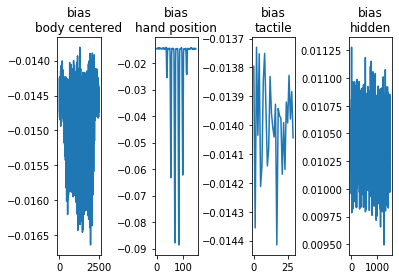

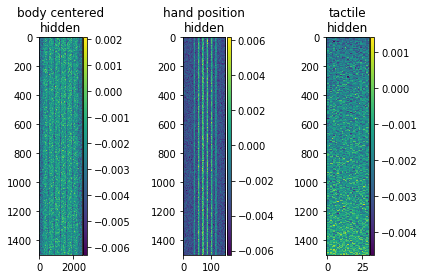

In [419]:
myw,myor = g.showpars(True)

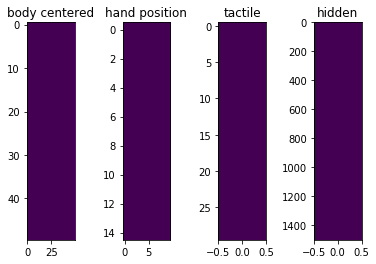

In [74]:
g.showstate()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

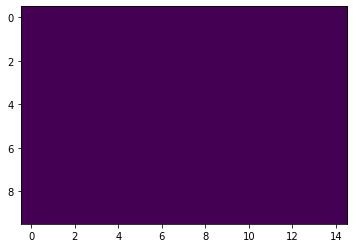

In [75]:
g.plotPop(1)

In [421]:
with open('myrbm.pkl', 'wb') as output:
    pickle.dump(g, output, pickle.HIGHEST_PROTOCOL)

<Figure size 432x288 with 0 Axes>

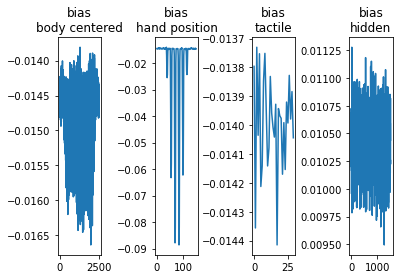

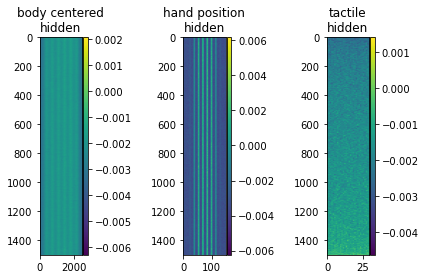

In [6]:
with open('myrbm.pkl', 'rb') as newinput:
    gload = pickle.load(newinput)
    gload.showpars(True)